# Anova

ANOVA (Analysis of Variance) is a statistical method used to determine whether there are significant differences between the means of three or more independent groups. It was developed by the statistician Ronald A. Fisher and is widely applied in experimental research, business analytics, social sciences, and biological studies.

ANOVA tests the null hypothesis that all group means are equal versus the alternative hypothesis that at least one group mean is different. It compares the variation between groups to the variation within groups.

If the variation between groups is significantly larger than the variation within groups, we infer that not all group means are equal.

## When to Use ANOVA

You should use ANOVA when:

1. Comparing Three or More Groups:
For example, testing whether three teaching methods lead to different student performances.
2. Dependent Variable is Continuous:
Such as test scores, income, or height.

3. Independent Variable is Categorical:
Such as gender, treatment type, or brand preference.

4. Assumptions Are Met:

   * The samples are independent.

   * The dependent variable is normally distributed within each group.

   * The variances of the groups are approximately equal (homogeneity of variance).

## Types of ANOVA

1. One-Way ANOVA:
Compares means across one factor (e.g., comparing average test scores across different schools).

2. Two-Way ANOVA:
Compares means across two factors (e.g., effect of teaching method and gender on performance).

3. Repeated Measures ANOVA:
Used when the same subjects are measured under multiple conditions or over time.

#### example: A researcher wants to test whether three different fertilizers lead to different average plant growth.
Here’s the sample data (in cm):

Test the hypothesis:

* H₀: All fertilizers produce the same mean plant growth.

* H₁: At least one fertilizer produces a different mean growth.

In [141]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [120]:
# Create data
data = {
    'Fertilizer': ['A']*5 + ['B']*5 + ['C']*5,
    'Growth': [20, 21, 19, 22, 20, 25, 27, 26, 25, 28, 23, 22, 21, 24, 23]
}

df = pd.DataFrame(data)
df.head()

,Fertilizer,Growth
0,A,20
1,A,21
2,A,19
3,A,22
4,A,20


### Perform One-Way ANOVA using SciPy

In [121]:
# Split data by groups
groupA = df[df['Fertilizer'] == 'A']['Growth']
groupB = df[df['Fertilizer'] == 'B']['Growth']
groupC = df[df['Fertilizer'] == 'C']['Growth']

In [122]:
# Perform ANOVA
f_stat, p_value = stats.f_oneway(groupA, groupB, groupC)

print("F-statistic:", round(f_stat, 3))
print("p-value:", round(p_value, 4))

F-statistic: 29.907
p-value: 0.0


Interpretation
* If p-value < 0.05, reject H₀ → at least one group mean differs.
* If p-value ≥ 0.05, fail to reject H₀ → no significant difference.

### Perform ANOVA using statsmodels (for a detailed table)

In [123]:
#create a model
model = ols('Growth ~ C(Fertilizer)', data=df).fit()

#plot the table
# ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)



                  sum_sq    df          F    PR(>F)
C(Fertilizer)  85.733333   2.0  29.906977  0.000022
Residual       17.200000  12.0        NaN       NaN


Observation: 
* Since the p-value < 0.05, we reject the null hypothesis.

Conclusion: 
* There is a statistically significant difference in mean plant growth between at least two fertilizers

#### Post Hoc Test (Tukey’s HSD)

To find which specific fertilizers differ, use Tukey’s test

In [124]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Growth'],        # dependent variable
                          groups=df['Fertilizer'],   # categorical variable
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B      5.8    0.0  3.7799  7.8201   True
     A      C      2.2 0.0328  0.1799  4.2201   True
     B      C     -3.6 0.0013 -5.6201 -1.5799   True
----------------------------------------------------


Observation

* 1. Fertilizer B yields significantly higher growth than A
* 2. Fertilizer C yields significantly higher growth than A, but the difference is smaller
* 3. Fertilizer B yields significantly higher growth than C (negative means B > C

In [125]:
tukey.plot_simultaneous?

<Figure size 800x500 with 0 Axes>

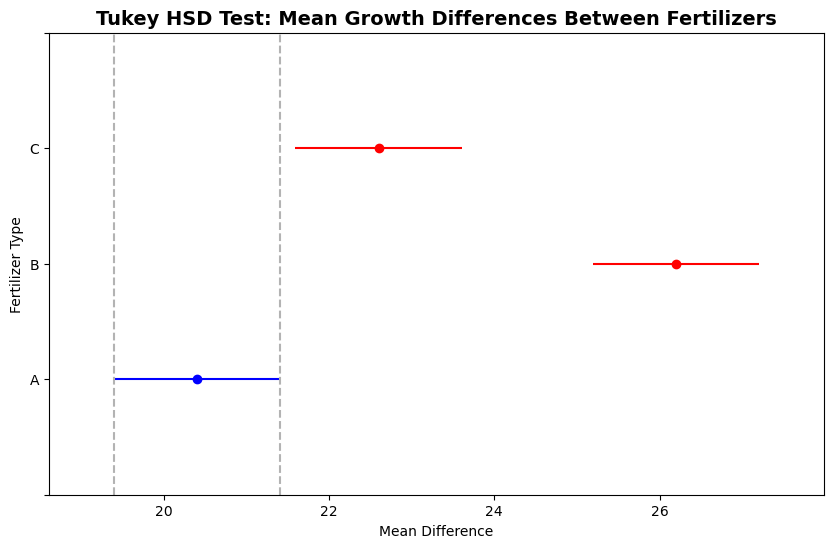

In [126]:
# Create the Tukey HSD plot
plt.figure(figsize=(8,5))
tukey.plot_simultaneous(comparison_name='A', xlabel='Mean Difference', ylabel='Fertilizer Type')
plt.title('Tukey HSD Test: Mean Growth Differences Between Fertilizers', fontsize=14, fontweight='bold')
plt.show();

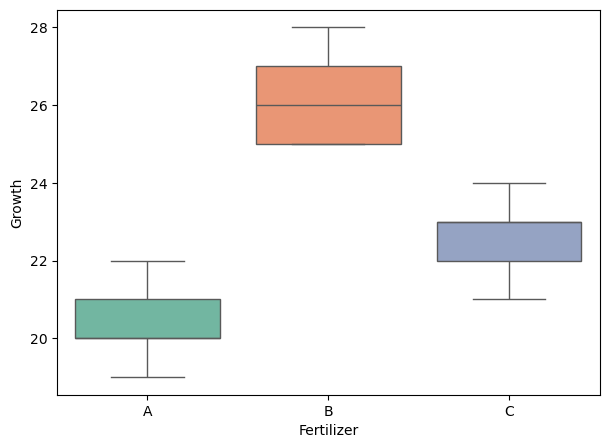

In [127]:
### Create boxplot
plt.figure(figsize=(7,5))
sns.boxplot(x='Fertilizer', y='Growth', data=df, palette='Set2');


Observation:
* Fertilizer B is the most effective for plant growth.

* Fertilizer A is the least effective.

* C is in between, but still performs significantly better than A.

### For publication/thesis purpose

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.lines import Line2D


# --- Run Tukey HSD test ---
tukey = pairwise_tukeyhsd(
    endog=df['Growth'],          # dependent variable
    groups=df['Fertilizer'],     # categorical independent variable
    alpha=0.05
)

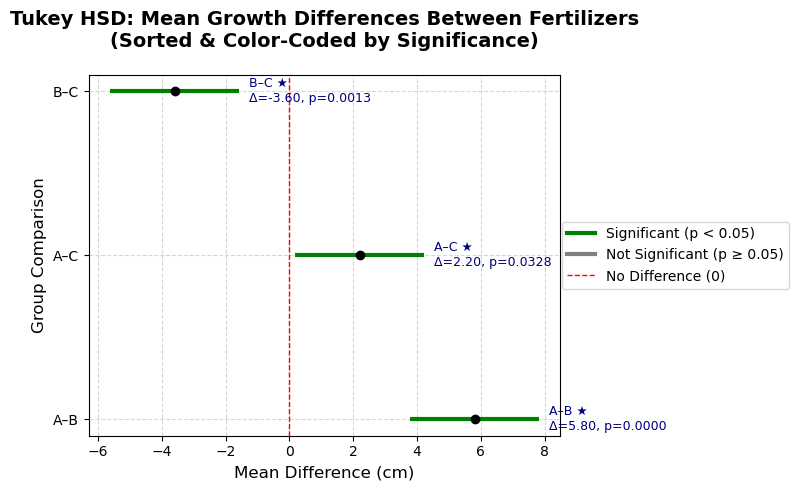

In [129]:
# --- Extract and sort results by mean difference (descending) ---
results = pd.DataFrame(
    tukey._results_table.data[1:],  # skip header row
    columns=tukey._results_table.data[0]
)
results['meandiff'] = results['meandiff'].astype(float)
results['lower'] = results['lower'].astype(float)
results['upper'] = results['upper'].astype(float)
results['p-adj'] = results['p-adj'].astype(float)
results['reject'] = results['reject'].astype(bool)

results = results.sort_values(by='meandiff', ascending=False).reset_index(drop=True)

# --- Create figure and axis ---
fig, ax = plt.subplots(figsize=(9, 5))

# --- Add reference line at zero (no difference) ---
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

# --- Plot each comparison with color coding ---
for y, row in results.iterrows():
    color = 'green' if row['reject'] else 'gray'

    # Plot confidence interval line
    ax.hlines(y=y, xmin=row['lower'], xmax=row['upper'], color=color, linewidth=3)

    # Plot mean difference marker
    ax.plot(row['meandiff'], y, 'o', color='black')

    # Label and stats
    label = f"{row['group1']}–{row['group2']}"
    significance = "★" if row['reject'] else ""
    p_text = f"p={row['p-adj']:.4f}"
    mean_text = f"Δ={row['meandiff']:.2f}"

    ax.text(row['upper'] + 0.3, y,
            f"{label} {significance}\n{mean_text}, {p_text}",
            va='center', fontsize=9, color='navy')

# --- Style axes and title ---
ax.set_yticks(np.arange(len(results)))
ax.set_yticklabels([f"{row['group1']}–{row['group2']}" for _, row in results.iterrows()])
ax.set_xlabel('Mean Difference (cm)', fontsize=12)
ax.set_ylabel('Group Comparison', fontsize=12)
ax.set_title('Tukey HSD: Mean Growth Differences Between Fertilizers\n(Sorted & Color-Coded by Significance)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.5)

# --- Add custom legend ---
legend_elements = [
    Line2D([0], [0], color='green', lw=3, label='Significant (p < 0.05)'),
    Line2D([0], [0], color='gray', lw=3, label='Not Significant (p ≥ 0.05)'),
    Line2D([0], [0], color='red', lw=1, linestyle='--', label='No Difference (0)')
]
ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1,0,0.5,1), frameon=True)

plt.tight_layout()

# --- Save high-quality figure ---
plt.savefig('tukey_HSD_sorted_colorcoded.png', dpi=300, bbox_inches='tight')
plt.savefig('tukey_HSD_sorted_colorcoded.pdf', bbox_inches='tight')

# --- Display plot ---
plt.show()

Observation
* Each horizontal line represents a 95% confidence interval for the difference between two group means.

* The vertical dashed line at 0 means “no difference.”

   * If a line does not cross zero, the difference between those two groups is statistically significant.

* The position of the line shows which group has the higher mean:

  * If the line is entirely to the right of 0, the second group has a higher mean.

  * If it’s to the left of 0, the first group has the higher mean.

- So, for the above data:
 
   * The A–B and A–C comparisons will be right of zero → meaning B and C outperform A.

  * The B–C line will be left of zero → meaning B outperforms C.

In [130]:
# Anova on iris dataset

Load a built-in dataset, e.g., "iris"
iris = sm.datasets.get_rdataset("iris").data
print(iris.head())
tukey = pairwise_tukeyhsd(endog=iris['Sepal.Length'],
                          groups=iris['Species'],
                          alpha=0.05)
print(tukey)

SyntaxError: invalid syntax (782920906.py, line 3)

In [ ]:
# 3️⃣ Convert results into DataFrame
# -----------------------------
results = pd.DataFrame(
    tukey._results_table.data[1:],  # skip header
    columns=tukey._results_table.data[0]
)
for col in ['meandiff', 'lower', 'upper', 'p-adj']:
    results[col] = results[col].astype(float)
results['reject'] = results['reject'].astype(bool)

# Sort comparisons by mean difference
results = results.sort_values(by='meandiff', ascending=False).reset_index(drop=True)

# -----------------------------
# 4️⃣ Create the visualization
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 5))
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

for y, row in results.iterrows():
    color = 'green' if row['reject'] else 'gray'

    # Confidence interval line
    ax.hlines(y=y, xmin=row['lower'], xmax=row['upper'], color=color, linewidth=3)
    # Mean difference marker
    ax.plot(row['meandiff'], y, 'o', color='black')

    # Labels with CI, p-value, and mean diff
    label = f"{row['group1']} vs {row['group2']}"
    direction = ">" if row['meandiff'] > 0 else "<"
    significance = "★" if row['reject'] else ""
    ci_text = f"95% CI [{row['lower']:.2f}, {row['upper']:.2f}]"
    text = f"{label} {direction} {significance}\nΔ={row['meandiff']:.2f}, p={row['p-adj']:.4f}\n{ci_text}"

    ax.text(row['upper'] + 0.15, y, text, va='center', fontsize=9, color='navy')

# -----------------------------
# 5️⃣ Style and add legend
# -----------------------------
ax.set_yticks(np.arange(len(results)))
ax.set_yticklabels([f"{row['group1']}–{row['group2']}" for _, row in results.iterrows()])
ax.set_xlabel('Mean Difference in Sepal Length (cm)', fontsize=12)
ax.set_ylabel('Species Comparison', fontsize=12)
ax.set_title('Tukey HSD: Sepal Length Differences Between Iris Species\n(Mean Differences with 95% Confidence Intervals)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.5)

legend_elements = [
    Line2D([0], [0], color='green', lw=3, label='Significant (p < 0.05)'),
    Line2D([0], [0], color='gray', lw=3, label='Not Significant'),
    Line2D([0], [0], color='red', lw=1, linestyle='--', label='No Difference (0)')
]
ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(2,0,.45,1), frameon=True)

plt.tight_layout()

# Save high-resolution versions
plt.savefig('iris_tukey_HSD.png', dpi=300, bbox_inches='tight')
plt.savefig('iris_tukey_HSD.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# Anova on mpg dataset
df = sns.load_dataset('mpg')

# -------------------------
# 2️⃣  Perform Tukey HSD test
# -------------------------
tukey = pairwise_tukeyhsd(endog=df['mpg'], groups=df['cylinders'], alpha=0.05)
print(tukey)

# -------------------------
# 3️⃣ Prepare the results for plotting
# -------------------------
results = pd.DataFrame(
    tukey._results_table.data[1:],  # skip header
    columns=tukey._results_table.data[0]
)
# Convert numeric columns to floats
for col in ['meandiff', 'lower', 'upper', 'p-adj']:
    results[col] = results[col].astype(float)
results['reject'] = results['reject'].astype(bool)

# Sort by mean difference
results = results.sort_values(by='meandiff', ascending=False).reset_index(drop=True)

# -------------------------
# 4️⃣ Plot results with color-coded significance + CI labels
# -------------------------
fig, ax = plt.subplots(figsize=(12, 8))
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)

for y, row in results.iterrows():
    color = 'green' if row['reject'] else 'gray'
    ax.hlines(y=y, xmin=row['lower'], xmax=row['upper'], color=color, linewidth=3)
    ax.plot(row['meandiff'], y, 'o', color='black')

    label = f"{int(row['group1'])} vs {int(row['group2'])}"
    direction = ">" if row['meandiff'] > 0 else "<"
    significance = "★" if row['reject'] else ""
    ci_text = f"95% CI [{row['lower']:.2f}, {row['upper']:.2f}]"
    text = f"{label} {direction} {significance}\nΔ={row['meandiff']:.2f}, p={row['p-adj']:.4f}\n{ci_text}"

    # Position text slightly to the right of upper CI
    ax.text(row['upper'] + 0.25, y, text, va='center', fontsize=9, color='navy')

# -------------------------
# 5️⃣ Format and decorate plot
# -------------------------
ax.set_yticks(np.arange(len(results)))
ax.set_yticklabels([f"{int(row['group1'])}–{int(row['group2'])}" for _, row in results.iterrows()])
ax.set_xlabel('Mean Difference in MPG', fontsize=12)
ax.set_ylabel('Cylinder Comparison', fontsize=12)
ax.set_title('Tukey HSD: Fuel Efficiency by Cylinder Count\n(Mean Differences with 95% Confidence Intervals)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.5)

# Legend
legend_elements = [
    Line2D([0], [0], color='green', lw=3, label='Significant (p < 0.05)'),
    Line2D([0], [0], color='gray', lw=3, label='Not Significant'),
    Line2D([0], [0], color='red', lw=1, linestyle='--', label='No Difference (0)')
]
ax.legend(handles=legend_elements, loc='center right',bbox_to_anchor=(1,0,0.5,1), frameon=True)

plt.tight_layout()
plt.savefig('tukey_cylinder_CI.png', dpi=300,bbox_inches='tight')
plt.savefig('tukey_cylinder_CI.pdf', bbox_inches='tight')
plt.show()

# CHI Square

The Chi-Square (χ²) test is a statistical test used to check relationships between categorical variables.

It tells you whether the observed frequencies (what you actually see) are significantly different from the expected frequencies (what you’d expect if there was no relationship).

There are two main types of Chi-Square tests:
| Type                                   | Purpose                                                  | Example                       |
| -------------------------------------- | -------------------------------------------------------- | ----------------------------- |
| **1. Chi-Square Test of Independence** | Checks if two categorical variables are related.         | Gender vs. Product Preference |
| **2. Chi-Square Goodness of Fit Test** | Checks if observed frequencies fit expected proportions. | Rolling a die — is it fair?   |


## Chi-Square Test of Independence Example

Let’s say we surveyed 100 people about Gender (Male/Female) and Product Preference (A/B).


In [152]:
#Import libraries
import pandas as pd
from scipy.stats import chi2_contingency

In [151]:
#create a dataframe in cntigent table format
a = np.array([[20,30], [25,25]])
df = pd.DataFrame(a, index=["Male", "Female"], columns=["ProdcutA", "ProductB"])
df

,ProdcutA,ProductB
Male,20,30
Female,25,25


### compute the expected values manually
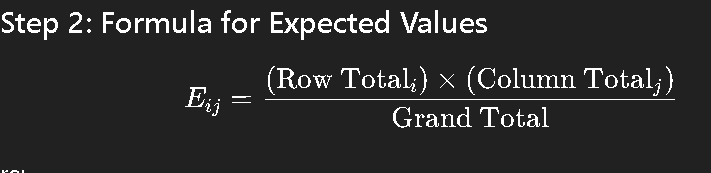


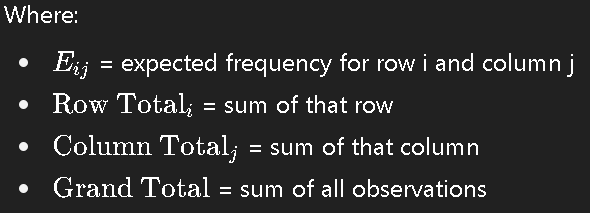

| Cell             | Formula       | Expected Value |
| :--------------- | :------------ | -------------: |
| Male–Product A   | (50 × 45)/100 |           22.5 |
| Male–Product B   | (50 × 55)/100 |           27.5 |
| Female–Product A | (50 × 45)/100 |           22.5 |
| Female–Product B | (50 × 55)/100 |           27.5 |


|            | Product A | Product B |
| :--------- | --------: | --------: |
| **Male**   |      22.5 |      27.5 |
| **Female** |      22.5 |      27.5 |



In [153]:
#The above can be done munually with python as well

import pandas as pd
import numpy as np

# Observed data
observed = pd.DataFrame({
    "ProductA": [20, 25],
    "ProductB": [30, 25]
}, index=["Male", "Female"])

# Calculate totals
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.values.sum()

# Compute expected values manually
expected = pd.DataFrame(
    np.outer(row_totals, col_totals) / grand_total,
    index=observed.index,
    columns=observed.columns
)

print("Observed:\n", observed)
print("\nExpected:\n", expected.round(2))


Observed:
         ProductA  ProductB
Male          20        30
Female        25        25

Expected:
         ProductA  ProductB
Male        22.5      27.5
Female      22.5      27.5


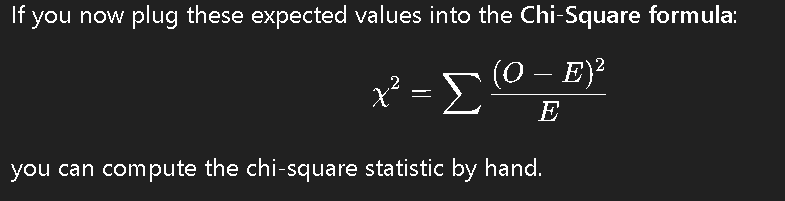

### we now perfom the above using chi-square package

In [154]:
from scipy.stats import chi2_contingency
# Perform Chi-Square Test of Independence/ confirm with the above
chi2, p, dof, expected = chi2_contingency(df)

print("\nChi-Square Statistic:", round(chi2, 3))
print("Degrees of Freedom:", dof)
print("P-Value:", round(p, 4))
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, columns=df.columns, index=df.index))
expected_df = pd.DataFrame(expected, columns=df.columns, index=df.index)


Chi-Square Statistic: 0.646
Degrees of Freedom: 1
P-Value: 0.4214

Expected Frequencies:
        ProdcutA  ProductB
Male        22.5      27.5
Female      22.5      27.5


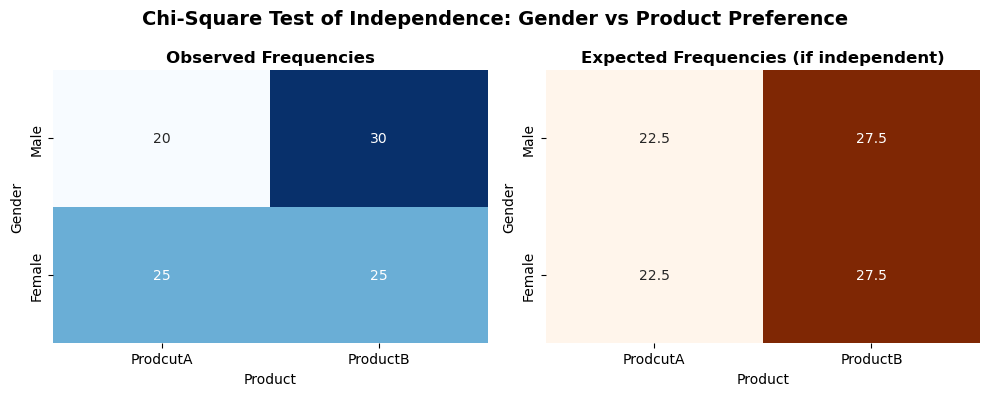

In [155]:
# Visualization: Heatmap (Observed vs Expected) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Observed frequencies
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Observed Frequencies', fontsize=12, fontweight='bold')

# Expected frequencies
sns.heatmap(expected_df, annot=True, fmt='.1f', cmap='Oranges', cbar=False, ax=axes[1])
axes[1].set_title('Expected Frequencies (if independent)', fontsize=12, fontweight='bold')

for ax in axes:
    ax.set_xlabel('Product')
    ax.set_ylabel('Gender')

plt.suptitle('Chi-Square Test of Independence: Gender vs Product Preference', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Observation
* The left heatmap shows the observed counts (actual data).

* The right heatmap shows the expected counts (if no relationship existed).

* The more these differ, the larger the chi-square statistic.

* If the p-value < 0.05, gender and product preference are dependent.

### additional
### Chi-Square Heatmap with Residuals

In [146]:
# --- Observed Data ---
# --- Step 1: Observed Data ---
observed = pd.DataFrame({
    "Product A": [20, 25],
    "Product B": [30, 25]
}, index=["Male", "Female"])

# --- Step 2: Perform Chi-Square Test ---
chi2, p, dof, expected = chi2_contingency(observed)
expected = pd.DataFrame(expected, index=observed.index, columns=observed.columns)

# --- Step 3: Calculate Residuals and Contributions ---
residuals = (observed - expected) / np.sqrt(expected)
contrib = (observed - expected) ** 2 / expected  # per-cell contribution
#threshold = contrib.values.flatten().max() * 0.5  # top 50% instead of 25%


# --- Print numerical outputs ---
print(f"Chi-Square Statistic: {chi2:.3f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}\n")

print("Expected Frequencies:\n", expected.round(2))
print("\nStandardized Residuals:\n", residuals.round(2))
print("\nCell Contributions to Chi-Square:\n", contrib.round(3))

Chi-Square Statistic: 0.646
Degrees of Freedom: 1
P-Value: 0.4214

Expected Frequencies:
         Product A  Product B
Male         22.5       27.5
Female       22.5       27.5

Standardized Residuals:
         Product A  Product B
Male        -0.53       0.48
Female       0.53      -0.48

Cell Contributions to Chi-Square:
         Product A  Product B
Male        0.278      0.227
Female      0.278      0.227


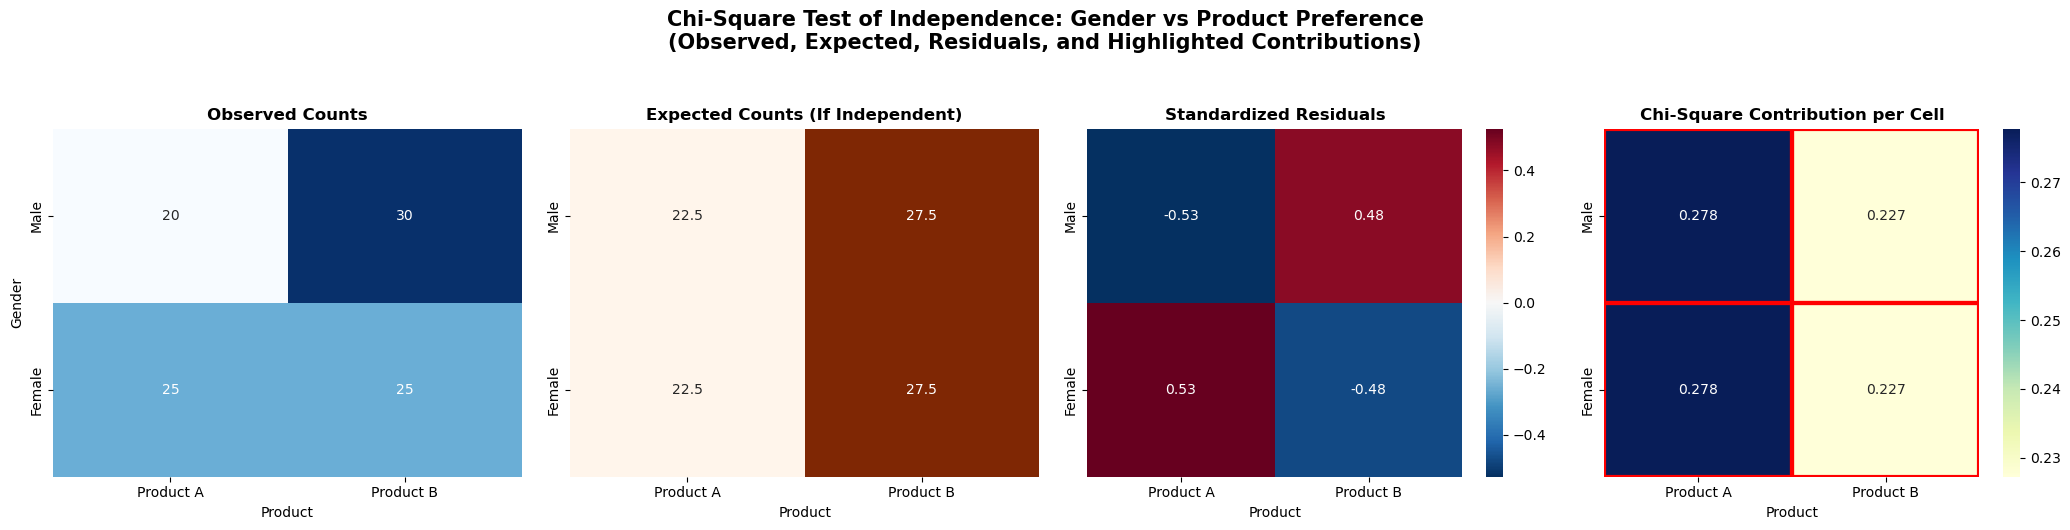

In [147]:
# --- Step 4: Plot Panels ---
fig, axes = plt.subplots(1, 4, figsize=(21, 5))

# Panel 1: Observed
sns.heatmap(observed, annot=True, fmt='.0f', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Observed Counts', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Product')
axes[0].set_ylabel('Gender')

# Panel 2: Expected
sns.heatmap(expected, annot=True, fmt='.1f', cmap='Oranges', cbar=False, ax=axes[1])
axes[1].set_title('Expected Counts (If Independent)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Product')
axes[1].set_ylabel('')

# Panel 3: Residuals
sns.heatmap(residuals, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[2])
axes[2].set_title('Standardized Residuals', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Product')
axes[2].set_ylabel('')

# Panel 4: Chi-Square Contributions (with highlights)
sns.heatmap(contrib, annot=True, fmt='.3f', cmap='YlGnBu', cbar=True, ax=axes[3])
axes[3].set_title('Chi-Square Contribution per Cell', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Product')
axes[3].set_ylabel('')

# Highlight top-contributing cells with red rectangles
for i in range(contrib.shape[0]):
    for j in range(contrib.shape[1]):
        if highlight_mask.iloc[i, j]:
            axes[3].add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))

# --- Titles and Layout ---
plt.suptitle('Chi-Square Test of Independence: Gender vs Product Preference\n'
             '(Observed, Expected, Residuals, and Highlighted Contributions)',
             fontsize=15, fontweight='bold', y=1.05)

plt.tight_layout()
plt.show()


Figure 1. Chi-Square test of independence between gender and product preference. The rightmost panel highlights cells contributing most to the overall Chi-Square statistic. Red-outlined cells deviate most from independence, helping identify which categories drive association.

Interpreting the Residuals
* 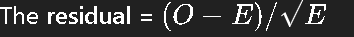

* Large positive residual → Observed count is higher than expected.
* Large negative residual → Observed count is lower than expected.
* Typically:
   * |Residual| > 2 → Strong contributor to Chi-Square statistic (significant deviation).
   

| Gender | Product | Observed | Expected | Contribution |
| ------ | ------- | -------- | -------- | ------------ |
| Male   | A       | 20       | 22.5     | 0.28         |
| Male   | B       | 30       | 27.5     | 0.24         |
| Female | A       | 25       | 22.5     | 0.28         |
| Female | B       | 25       | 27.5     | 0.24         |


Each contribution ≈ 0.25, so no cell dominates — consistent with an overall weak Chi-Square (χ² ≈ 0.91, p = 0.34).


Four panels:

* Observed counts

* Expected counts

* Standardized residuals

* Chi-Square contributions (highlighted)

* On the contribution heatmap, cells outlined in red boxes are those that contribute the most to the Chi-Square statistic — i.e., where the observed values deviate most from what’s expected under independence.

## Chi-Square Goodness-of-Fit Visualization


Chi-Square Statistic: 1.120
P-Value: 0.9523


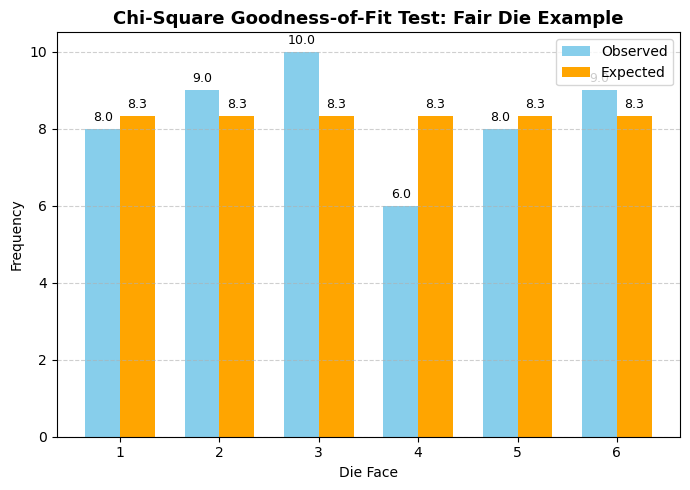

In [116]:
#example
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# Observed outcomes from rolling a die
observed = np.array([8, 9, 10, 6, 8, 9])
expected = np.array([sum(observed)/6] * 6)
faces = ['1', '2', '3', '4', '5', '6']

# Perform Chi-Square test
chi2, p = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Statistic: {chi2:.3f}")
print(f"P-Value: {p:.4f}")

#Visualization 2: Bar Chart of Observed vs Expected ---
x = np.arange(len(faces))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, observed, width, label='Observed', color='skyblue')
bars2 = ax.bar(x + width/2, expected, width, label='Expected', color='orange')

# Add text annotations
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.1f}', ha='center', fontsize=9)

# Labels and formatting
ax.set_xlabel('Die Face')
ax.set_ylabel('Frequency')
ax.set_title('Chi-Square Goodness-of-Fit Test: Fair Die Example', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(faces)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Interpretation

* The bars show how close your observed frequencies are to expected.

* If bars are roughly equal → p-value ≥ 0.05 → no significant difference → the die could be fair.

* If bars differ greatly → p-value < 0.05 → the die is likely biased.


Take note on Visualization:

| Visualization | Purpose                                                      | Tool                |
| ------------- | ------------------------------------------------------------ | ------------------- |
| **Heatmap**   | Compare observed vs expected counts (Independence Test)      | `seaborn.heatmap()` |
| **Bar Chart** | Compare observed vs expected distributions (Goodness-of-Fit) | `matplotlib.bar()`  |
